# Chapter 07 Relationships Between Variables

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import brfss

import thinkstats2
import thinkplot

So far we have only looked at one variable at a time. In this chapter we look at relationships between variables.

Two variables are related if knowing one gives you information about the other.

For example, height and weight are related; people who are taller tend to be heavier. Of course, it is not a perfect relationship: there are short heavy people and tall light ones. But if you are trying to guess someone’s weight, you will be more accurate if you know their height than if you don’t.

## Scatter plots

The simplest way to check for a relationship between two variables is a scatter plot, but making a good scatter plot is not always easy. As an example, we’ll plot weight versus height for the respondents in the BRFSS

We'll start with the data from the BRFSS again.

In [16]:
df = brfss.ReadBrfss(nrows=None)

In [17]:
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


The following function selects a random subset of a `DataFrame`.

In [18]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

`df` is the DataFrame, `nrows` is the number of rows to choose, and `replace` is a boolean indicating whether sampling should be done with replacement; in other words, whether the same row could be chosen more than once.

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [19]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

thinkplot provides Scatter, which makes scatter plots:

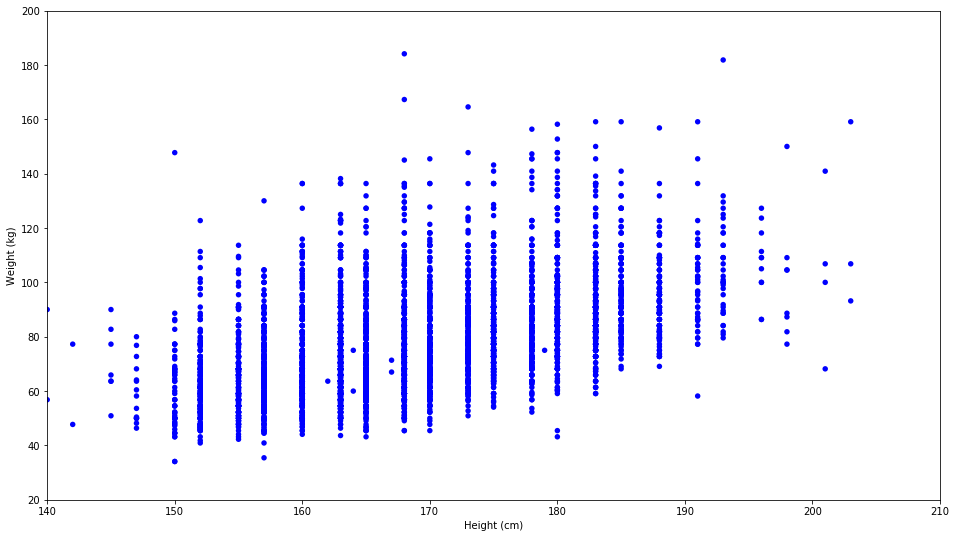

In [20]:
plt.figure(figsize=(16,9))
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The result, in Figure above, shows the shape of the relationship. As we expected, taller people tend to be heavier.

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noice to the data.

But this is not the best representation of the data, because the data are packed into columns. The problem is that the heights are rounded to the nearest inch, converted to centimeters, and then rounded again. Some information is lost in translation.

NOTE: The version of `Jitter` in the library uses noise with a uniform distribution.  Here we are using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [21]:
def Jitter(values, jitter=0.5):
    n = len(values)
    # return np.random.uniform(-jitter, +jitter, n) + values
    return np.random.normal(0, jitter, n) + values

The `values` can be any sequence; the result is a NumPy array.

We can’t get that information back, but we can minimize the effect on the scatter plot by jittering the data, which means adding random noise to reverse the effect of rounding off. 

Since these measurements were rounded to the nearest inch, they might be off by up to 0.5 inches or 1.4 cm. Similarly, the weights might be off by 0.5 kg.

Heights were probably rounded off to the nearest inch, which is 2.8 cm, so I'll add random values from -1.4 to 1.4.

In [22]:
heights = Jitter(heights, 1.4)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

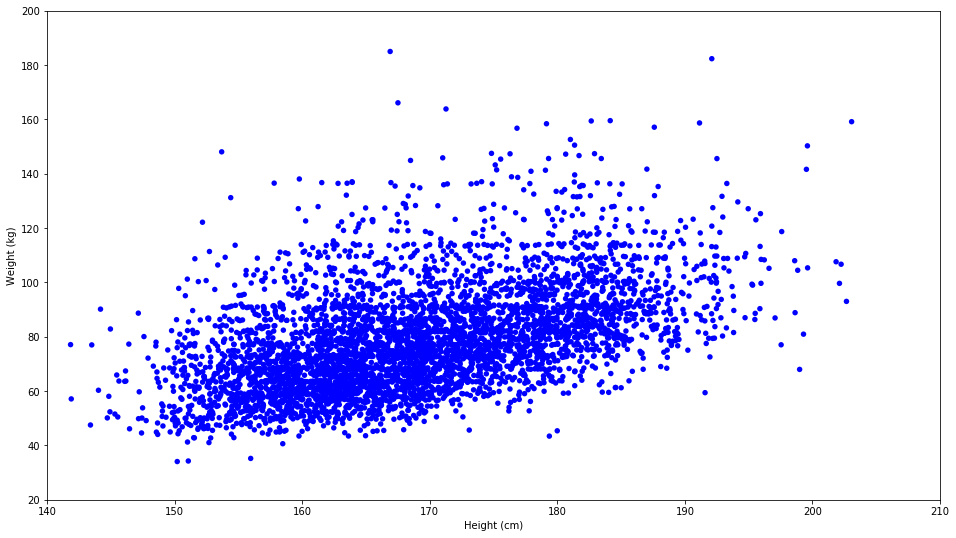

In [23]:
plt.figure(figsize=(16,9))
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

Jittering reduces the visual effect of rounding and makes the shape of the relationship clearer. But in general you should only jitter data for purposes of visualization and avoid using jittered data for analysis.

The columns are gone, but now we have a different problem: saturation.

Even with jittering, this is not the best way to represent the data. There are many overlapping points, which hides data in the dense parts of the figure and gives disproportionate emphasis to outliers. This effect is called **saturation**.

Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

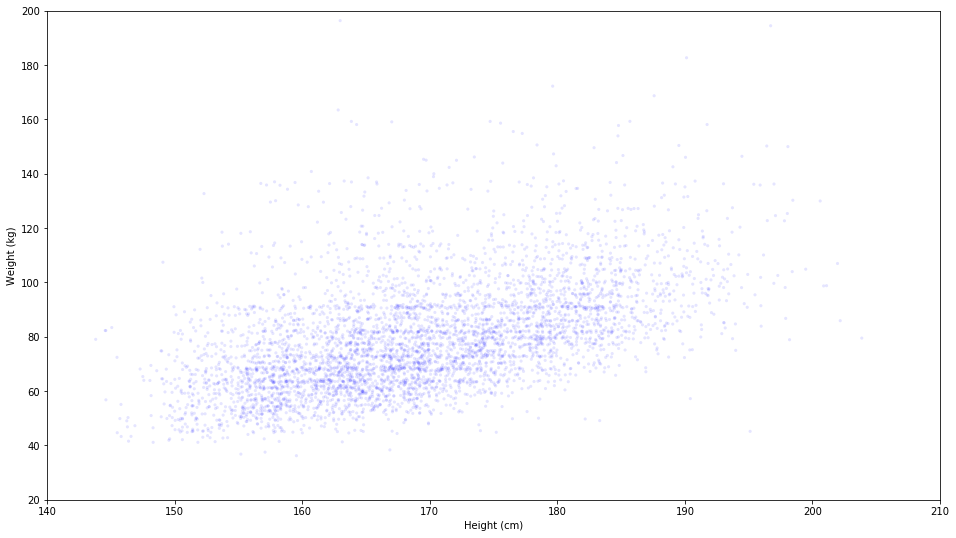

In [14]:
plt.figure(figsize=(16,9))
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better. This version of the figure shows the location and shape of the distribution most accurately.

Overlapping data points look darker, so darkness is proportional to density. In this version of the plot we can see two details that were not apparent before: vertical clusters at several heights and a horizontal line near 90 kg or 200 pounds. 

Since this data is based on self-reports in pounds, the most likely explanation is that some respondents reported rounded values.

There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

Using transparency works well for moderate-sized datasets, but this figure only shows the first 5000 records in the BRFSS, out of a total of 414,509.

To handle larger datasets, another option is a hexbin plot, which divides the graph into hexagonal bins and colors each bin according to how many data points fall in it.

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

thinkplot provides `HexBin`:

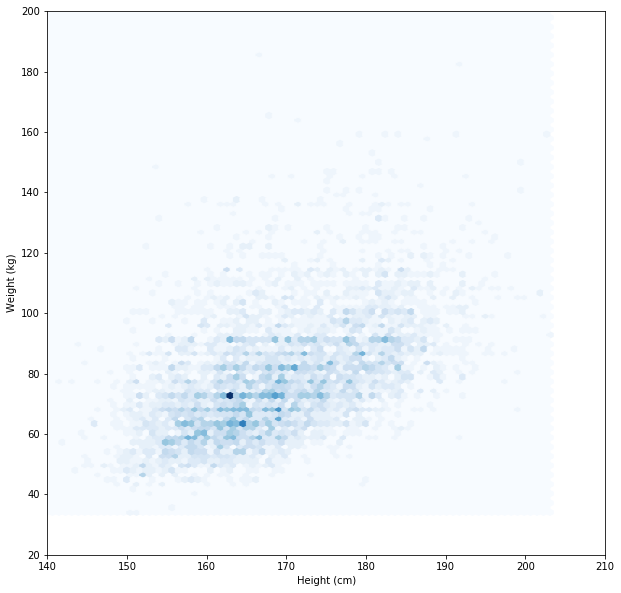

In [26]:
plt.figure(figsize=(10,10))
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

An advantage of a hexbin is that it shows the shape of the relationship well, and it is efficient for large datasets, both in time and in the size of the file it generates. A drawback is that it makes the outliers invisible.

## Characterizing Relationships
Scatter plots provide a general impression of the relationship between variables, but there are other visualizations that provide more insight into the nature of the relationship.

One option is to bin one variable and plot percentiles of the other. NumPy and pandas provide functions for binning data.

### Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

For example, as height is increasing (in groups), how is the 25th percentile of weight increasing? How is median increasing? How is 75th percentile increasing?

First we'll drop any rows that are missing height or weight.

In [27]:
# dropna drops rows with nan in any of the listed columns
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

In [28]:
cleaned.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0
5,42.0,1,118.181818,415.161314,109.09,183.0


Then I'll divide the dataset into groups by height. `arange` makes a NumPy array of bins from 135 to, but not including, 210, in increments of 5.

In [29]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

In [30]:
bins

array([135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205])

In [31]:
indices

array([5, 6, 8, ..., 9, 5, 9], dtype=int64)

`digitize` computes the index of the bin that contains each value in `df.htm3`. The result is a NumPy array of integer indices.

Values that fall below the lowest bin are mapped to index 0. Values above the highest bin are mapped to len(bins).

`groupby` is a DataFrame method that returns a GroupBy object; used in a for loop, groups iterates the names of the groups and the DataFrames that represent them. 

So, for example, we can print the number of rows in each group like this:

In [32]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now for each group we can compute the mean height and the CDF of weight:

In [33]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

In [34]:
mean_heights

[120.12459016393443,
 135.78508771929825,
 141.43396226415095,
 146.33718778908417,
 151.52843968228584,
 156.3503419942746,
 161.67421045177736,
 166.56972746679975,
 171.40954232482787,
 176.54908086026674,
 181.57596142807944,
 186.32469990536435,
 191.7859712230216,
 196.6426561620709,
 201.73827160493826,
 210.58778625954199]

In [35]:
cdfs

[Cdf([ 22.73  25.    27.27  29.55  30.    30.45  31.82  32.27  32.73  34.09
   34.55  35.45  35.91  36.36  36.82  38.18  38.64  40.91  41.82  42.73
   43.18  44.09  44.55  45.    45.45  45.91  46.36  46.82  47.27  47.73
   48.18  49.55  50.    50.91  51.82  52.27  52.73  53.18  53.64  54.09
   54.55  55.    56.82  57.27  58.18  58.64  59.09  59.55  60.    60.45
   61.36  61.82  62.27  62.73  63.18  63.64  64.55  65.    65.45  65.91
   66.36  66.82  67.27  67.73  68.18  68.64  69.09  69.55  70.    70.45
   70.91  71.    71.36  71.82  72.27  72.73  74.55  75.    76.36  76.82
   77.27  79.55  80.    80.91  81.82  83.18  84.09  84.55  85.    85.91
   86.36  88.18  90.    90.91  95.45  96.36 104.55 113.64 120.   121.82
  122.73 125.   149.09 181.82], [0.01639344 0.01967213 0.02295082 0.02622951 0.0295082  0.03278689
  0.03934426 0.04262295 0.04590164 0.05245902 0.0557377  0.05901639
  0.06229508 0.06885246 0.07213115 0.07868852 0.08196721 0.0852459
  0.09180328 0.09508197 0.10819672 0.11147

And then extract the 25th, 50th, and 75th percentile from each group.

Finally, we can plot percentiles of weight versus height.

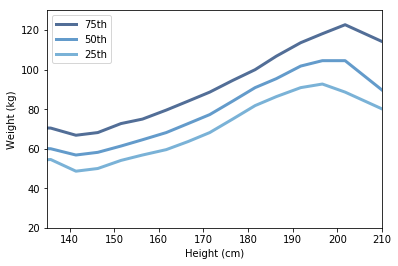

In [36]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[135, 210, 20, 130],
                 legend=True)

Between 140 and 200 cm the relationship between these variables is roughly linear. This range includes more than 99% of the data, so we don’t have to worry too much about the extremes.

Remember, height is divided into bins:

[135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205]

For every bin, we have a values of weights. We are taking the percentiles of the weights for each bin and plotting it against heights.

As height increases, the 25th, 50th and 75th percentiles of weight are also increasing. 

## Correlation
A **correlation** is a statistic intended to quantify the strength of the relationship between two variables.

A challenge in measuring correlation is that the variables we want to compare are often not expressed in the same units. And even if they are in the same units, they come from different distributions.

There are two common solutions to these problems:
* Transform each value to a **standard scores**(z-scores), which is the number of standard deviations from the mean. This transform leads to the *“Pearson product-moment correlation coefficient.”*
* Transform each value to its **rank**, which is its index in the sorted list of values. This transform leads to the *“Spearman rank correlation coefficient.”*

If X is a series of n values, $x_i$, we can convert to standard scores by subtracting the mean and dividing by the standard deviation: $z_i = \frac{(x_i - \mu)}{\sigma}$.

The numerator is a deviation: the distance from the mean. Dividing by $\sigma$ standardizes the deviation, so the values of Z are dimensionless (no units) and their distribution has mean 0 and variance 1.

If X is normally distributed, so is Z. But if X is skewed or has outliers, so does Z; in those cases, it is more robust to use percentile ranks. If we compute a new variable, R, so that $r_i$ is the rank of $x_i$, the distribution of R is uniform from 1 to n, regardless of the distribution of X.

# Covariance
Covariance is a measure of the tendency of two variables to vary together. If we have two series, X and Y, their deviations from the mean are

$dx_i = x_i - \bar x$<br>
$dy_i = y_i - \bar y$

where $\bar x$ is the sample mean of X and $\bar y$ is the sample mean of Y. If X and Y vary together, their deviations tend to have the same sign.

If we multiply them together, the product is positive when the deviations have the same sign and negative when they have the opposite sign. So adding up the products gives a measure of the tendency to vary together.

Covariance is the mean of these products:<br>
$Cov(X,Y) = \frac{1}{n} \sum dx_i \space dy_i$

where n is the length of the two series (they have to be the same length).

If you have studied linear algebra, you might recognize that `Cov` is the dot product of the deviations, divided by their length. So the covariance is maximized if the two vectors are identical, 0 if they are orthogonal, and negative if they point in opposite directions.

`thinkstats2` uses `np.dot` to implement `Cov` efficiently:

The following function computes the covariance of two variables using NumPy's `dot` function.

In [37]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [38]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.3329085769776

By default `Cov` computes deviations from the sample means, or you can provide known means. If `xs` and `ys` are Python sequences, `np.asarray` converts them to `NumPy` arrays.

If they are already `NumPy` arrays, `np.asarray` does nothing.

This implementation of covariance is meant to be simple for purposes of explanation. `NumPy` and pandas also provide implementations of covariance, but both of them apply a correction for small sample sizes that we have not covered yet, and `np.cov` returns a covariance matrix, which is more than we need for now.

# Pearson’s Correlation

Covariance is useful in some computations, but it is seldom reported as a summary statistic because it is hard to interpret.

Among other problems, its units are the product of the units of X and Y. For example, the covariance of weight and height in the BRFSS dataset is 103 kilogram-centimeters, whatever that means.

One solution to this problem is to divide the deviations by the standard deviation, which yields standard scores, and compute the product of standard scores:

$p_i = \frac{(x_i - \bar x)}{S_X} \frac{(y_i - \bar y)}{S_Y}$

Where $S_X$ and $S_Y$ are the standard deviations of X and Y. The mean of these products is

$\rho = \frac{1}{n} \sum p_i$

Or we can rewrite $\rho$ by factoring out $S_X$ and $S_Y$:

$\rho = \frac{Cov(X,Y)}{S_x S_y}$

This value is called **Pearson’s correlation** after Karl Pearson, an influential early statistician. It is easy to compute and easy to interpret. Because standard scores are dimensionless, so is $\rho$.

Here is the implementation in thinkstats2:

In [39]:
# Covariance is useful for some calculations, but it doesn't mean much by itself.  
# The coefficient of correlation is a standardized version of covariance that is easier to interpret.

def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [40]:
Corr(heights, weights)

0.5087364789734607

`MeanVar` computes mean and variance slightly more efficiently than separate calls to `np.mean` and `np.var`.

Pearson’s correlation is always between -1 and +1 (including both). If $\rho$ is positive, we say that the correlation is positive, which means that when one variable is high, the other tends to be high. 

If $\rho$ is negative, the correlation is negative, so when one variable is high, the other is low.

The magnitude of $\rho$ indicates the strength of the correlation. If $\rho$ is 1 or -1, the variables are perfectly correlated, which means that if you know one, you can make a perfect prediction about the other.

Most correlation in the real world is not perfect, but it is still useful. The correlation of height and weight is 0.51, which is a strong correlation compared to similar humanrelated variables.

NumPy provides a function that computes correlations, too:

In [41]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

# Nonlinear Relationships
If Pearson’s correlation is near 0, it is tempting to conclude that there is no relationship between the variables, but that conclusion is not valid. 

Pearson’s correlation only measures linear relationships. If there’s a nonlinear relationship, $\rho$ understates its strength.

Figure below is for correlation and dependence. It shows scatter plots and correlation coefficients for several carefully constructed datasets.

![Correlation examples](https://upload.wikimedia.org/wikipedia/commons/0/02/Correlation_examples.png)

The top row shows linear relationships with a range of correlations; you can use this row to get a sense of what different values of $\rho$ look like.

The second row shows perfect correlations with a range of slopes, which demonstrates that correlation is unrelated to slope (we’ll talk about estimating slope soon). 

The third row shows variables that are clearly related, but because the relationship is non-linear, the correlation coefficient
is 0.

The moral of this story is that you should always look at a scatter plot of your data before blindly computing a correlation coefficient.

# Spearman’s Rank Correlation
Pearson’s correlation works well if the relationship between variables is linear and if the variables are roughly normal. But it is not robust in the presence of outliers. **Spearman’s rank correlation** is an alternative that mitigates the effect of outliers and skewed distributions.

To compute Spearman’s correlation, we have to compute the rank of each value, which is its index in the sorted sample. For example, in the sample [1, 2, 5, 7] the rank of the value 5 is 3, because it appears third in the sorted list. Then we compute Pearson’s correlation for the ranks.

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic ((of a function or quantity) varying in such a way that it either never decreases or never increases).  Here's a function that computes Spearman's correlation:

In [42]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

We convert the arguments to pandas Series objects so I can use `rank`, which computes the rank for each value and returns a Series. Then I use `Corr` to compute the correlation of the ranks.

For heights and weights, Spearman's correlation is a little higher:

In [43]:
SpearmanCorr(heights, weights)

0.5405846262320476

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [44]:
# We could also use Series.corr directly and specify Spearman’s method
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [45]:
SpearmanCorr(heights, weights)

0.5405846262320491

The Spearman rank correlation for the BRFSS data is 0.54, which is a little higher than the Pearson correlation, 0.51. There are several possible reasons for the difference, including the following:
* If the relationship is nonlinear, Pearson’s correlation tends to underestimate the strength of the relationship.
* Pearson’s correlation can be affected (in either direction) if one of the distributions is skewed or contains outliers. Spearman’s rank correlation is more robust.

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In the BRFSS example, we know that the distribution of weights is roughly lognormal; under a log transform, it approximates a normal distribution, so it has no skew. So another way to eliminate the effect of skewness is to compute Pearson’s correlation with log-weight and height:

In [46]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.5317282605983452

The result is 0.53, close to the rank correlation, 0.54. So that suggests that skewness in the distribution of weight explains most of the difference between Pearson’s and Spearman’s correlation.

# Correlation and Causation
If variables A and B are correlated, there are three possible explanations: 
* A causes B, or
* B causes A, or 
* some other set of factors causes both A and B. 

These explanations are called **“causal relationships”**.

Correlation alone does not distinguish between these explanations, so it does not tell you which ones are true. This rule is often summarized with the phrase **“Correlation does not imply causation,”** which is so pithy, it has its own [Wikipedia page](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation).

So what can you do to provide evidence of causation?
* **Use time.** If A comes before B, then A can cause B but not the other way around (at least according to our common understanding of causation). The order of events can help us infer the direction of causation, but it does not preclude the possibility that something else causes both A and B.
* **Use randomness.** If you divide a large sample into two groups at random and compute the means of almost any variable/feature, you expect the difference to be small. If the groups are nearly identical in all variables but one, you can eliminate spurious (not being what it purports to be; false or fake) relationships.

This works even if you don’t know what the relevant variables are, but it works even better if you do, because you can check that the groups are identical.

These ideas are the motivation for the [**randomized controlled trial**](https://www.youtube.com/watch?v=YkF-pum0JP4), in which subjects are assigned randomly to two (or more) groups: a **treatment group** that receives some kind of intervention, like a new medicine, and a **control group** that receives no intervention, or another treatment whose effects are known. (There may also be a **Placebo or Nocebo** group)

A randomized controlled trial is the most reliable way to demonstrate a causal relationship, and it is the foundation of science-based medicine.

Unfortunately, controlled trials are only possible in the laboratory sciences, medicine, and a few other disciplines. In the social sciences, controlled experiments are rare, usually because they are impossible or unethical.

An alternative is to look for a natural experiment, where different “treatments” are applied to groups that are otherwise similar. One danger of natural experiments is that the groups might differ in ways that are not apparent.

In some cases it is possible to infer causal relationships using regression analysis.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatterplot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

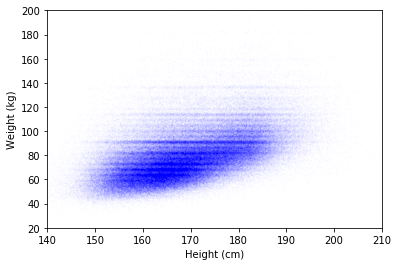

In [49]:
# Solution

# With smaller markers, we needed more aggressive jittering to
# blur the measurement artifacts

# With this dataset, using all of the rows might be more trouble
# than it's worth.  Visualizing a subset of the data might be
# more practical and more effective.

heights = Jitter(df.htm3, 2.8)
weights = Jitter(df.wtkg2, 1.0)

thinkplot.Scatter(heights, weights, alpha=0.01, s=2)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

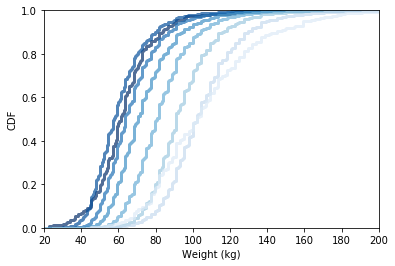

In [50]:
# Solution

bins = np.arange(140, 210, 10)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(xlabel='Weight (kg)',
                 ylabel='CDF',
                 axis=[20, 200, 0, 1],
                 legend=False)

**Exercise:** Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [51]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [52]:
# Solution

ages = live.agepreg
weights = live.totalwgt_lb
print('Corr', Corr(ages, weights))
print('SpearmanCorr', SpearmanCorr(ages, weights))

Corr 0.06883397035410908
SpearmanCorr 0.09461004109658226


In [53]:
# Solution

def BinnedPercentiles(df):
    """Bin the data by age and plot percentiles of weight for each bin.

    df: DataFrame
    """
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df.agepreg, bins)
    groups = df.groupby(indices)

    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)

    thinkplot.Config(xlabel="Mother's age (years)",
                     ylabel='Birth weight (lbs)',
                     xlim=[14, 45], legend=True)

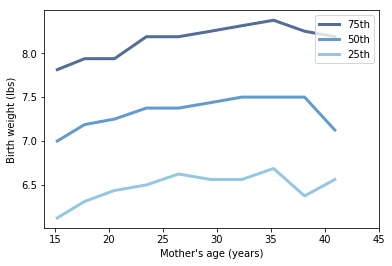

In [54]:
BinnedPercentiles(live)

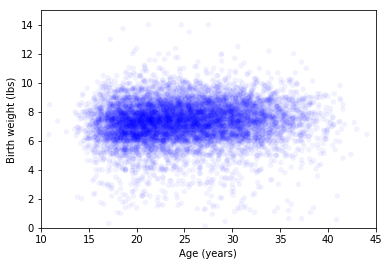

In [55]:
# Solution

def ScatterPlot(ages, weights, alpha=1.0, s=20):
    """Make a scatter plot and save it.

    ages: sequence of float
    weights: sequence of float
    alpha: float
    """
    thinkplot.Scatter(ages, weights, alpha=alpha)
    thinkplot.Config(xlabel='Age (years)',
                     ylabel='Birth weight (lbs)',
                     xlim=[10, 45],
                     ylim=[0, 15],
                     legend=False)
    
ScatterPlot(ages, weights, alpha=0.05, s=10)

Solution

My conclusions:

1) The scatterplot shows a weak relationship between the variables but it is hard to see clearly.

2) The correlations support this.  Pearson's is around 0.07, Spearman's is around 0.09.  The difference between them suggests some influence of outliers or a non-linear relationsip.

3) Plotting percentiles of weight versus age suggests that the relationship is non-linear.  Birth weight increases more quickly in the range of mother's age from 15 to 25.  After that, the effect is weaker.